In [2]:
import os
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
from models import shufflenetv2, nasnet_mobile_onfire
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def load_model(model_name, weight_path, device):
    if model_name == "shufflenetonfire":
        model = shufflenetv2.shufflenet_v2_x0_5(pretrained=False, layers=[4, 8, 4],
                                                output_channels=[24, 48, 96, 192, 64], num_classes=1)
    elif model_name == "nasnetonfire":
        model = nasnet_mobile_onfire.nasnetamobile(num_classes=1, pretrained=False)
    else:
        raise ValueError("Invalid model name. Choose 'shufflenetonfire' or 'nasnetonfire'.")
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    model.to(device)
    return model

def get_transform(model_name):
    if model_name == 'shufflenetonfire':
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    elif model_name == 'nasnetonfire':
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

def preprocess_image(image_path, transform, device):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224), cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = transform(image).float().unsqueeze(0).to(device)
    return image

def detect_fire(image_path, model, transform, device):
    image_tensor = preprocess_image(image_path, transform, device)
    output = model(image_tensor)
    prediction = torch.round(torch.sigmoid(output)).item()
    return "Fire" if prediction == 0 else "No Fire"

In [5]:
def generate_roc_data(folder_path, model_name="shufflenetonfire", weight_path="weights/shufflenet_ff.pt"):
    """
    Generate ROC curve data for fire detection model using all validation data.
    
    Returns:
        dict: Dictionary containing ROC curve data and model performance metrics
    """
    from sklearn.metrics import roc_curve, auc
    import numpy as np
    
    # Check if required subdirectories exist
    fire_path = os.path.join(folder_path, "fire")
    no_fire_path = os.path.join(folder_path, "no-fire")
    
    if not (os.path.exists(fire_path) and os.path.exists(no_fire_path)):
        raise ValueError("Both 'fire' and 'no-fire' subdirectories must exist")
    
    # Setup model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = load_model(model_name, weight_path, device)
    transform = get_transform(model_name)
    
    def predict_proba(image_path):
        """Return probability score for an image"""
        image_tensor = preprocess_image(image_path, transform, device)
        with torch.no_grad():
            output = model(image_tensor)
            return torch.sigmoid(output).item()
    
    # Get all valid image files
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")
    fire_images = [os.path.join(fire_path, f) for f in os.listdir(fire_path) 
                  if f.lower().endswith(valid_extensions)]
    no_fire_images = [os.path.join(no_fire_path, f) for f in os.listdir(no_fire_path) 
                     if f.lower().endswith(valid_extensions)]
    
    # Create list of all images and their true labels
    all_images = fire_images + no_fire_images
    y_true = np.array([0] * len(fire_images) + [1] * len(no_fire_images))
    
    # Get predictions for all images
    print("Processing all images...")
    y_scores = np.array([predict_proba(img) for img in tqdm(all_images)])
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold using Youden's J statistic
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    return {
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'optimal_tpr': tpr[optimal_idx],
        'optimal_fpr': fpr[optimal_idx],
        'y_true': y_true,
        'y_scores': y_scores
    }

def plot_roc_curve(roc_data, title="Receiver Operating Characteristic (ROC) Curve", color='darkorange', bg_color='white'):
    """
    Plot ROC curve from pre-generated data.
    
    Args:
        roc_data (dict): Dictionary containing ROC curve data
        title (str): Title for the plot
    """
    import matplotlib.pyplot as plt
    
    # Extract data
    fpr = roc_data['fpr']
    tpr = roc_data['tpr']
    roc_auc = roc_data['auc']
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color=color, lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    plt.gcf().set_facecolor(bg_color)
    # Adjust axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # Set axis labels and title with larger font sizes
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(title, fontsize=18)
    
    plt.xticks(fontsize=14)  # Adjust the fontsize for x-axis ticks
    plt.yticks(fontsize=14)

    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    plt.show()
    
    # Print performance metrics
    print(f"\nArea Under Curve (AUC): {roc_auc:.3f}")
    print(f"Optimal threshold: {roc_data['optimal_threshold']:.3f}")
    print(f"At optimal threshold:")
    print(f"True Positive Rate: {roc_data['optimal_tpr']:.3f}")
    print(f"False Positive Rate: {roc_data['optimal_fpr']:.3f}")

In [13]:
# Example usage:
aggregate_data = generate_roc_data("val-data/aggregate")
daytime_data = generate_roc_data("val-data/day")
nighttime_data = generate_roc_data("val-data/night")



Processing all images...


100%|██████████| 202/202 [00:06<00:00, 29.31it/s]


Processing all images...


100%|██████████| 119/119 [00:02<00:00, 41.27it/s]


Processing all images...


100%|██████████| 83/83 [00:03<00:00, 22.44it/s]


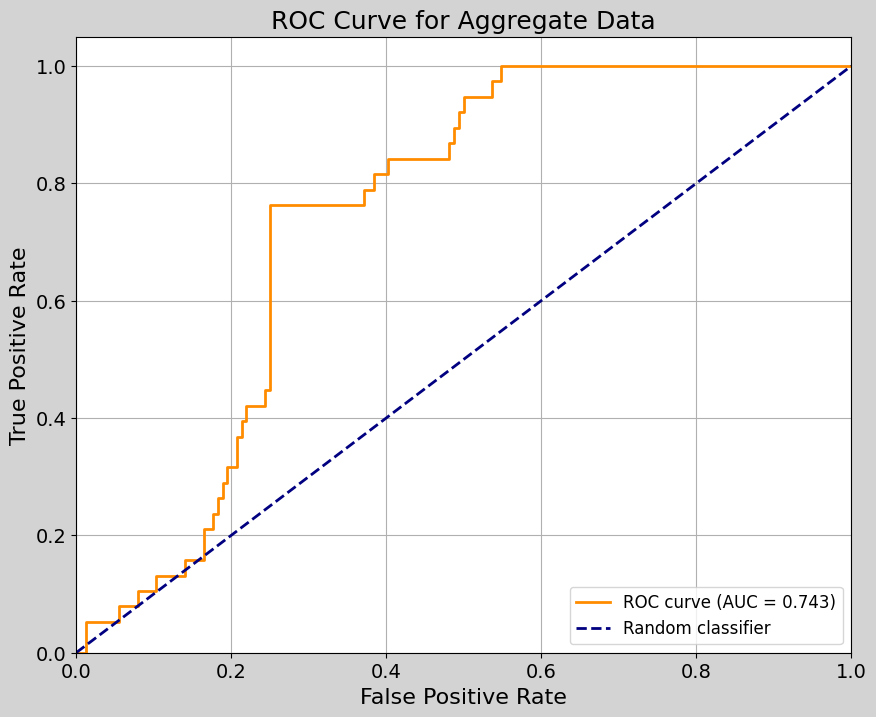


Area Under Curve (AUC): 0.743
Optimal threshold: 0.999
At optimal threshold:
True Positive Rate: 0.763
False Positive Rate: 0.250


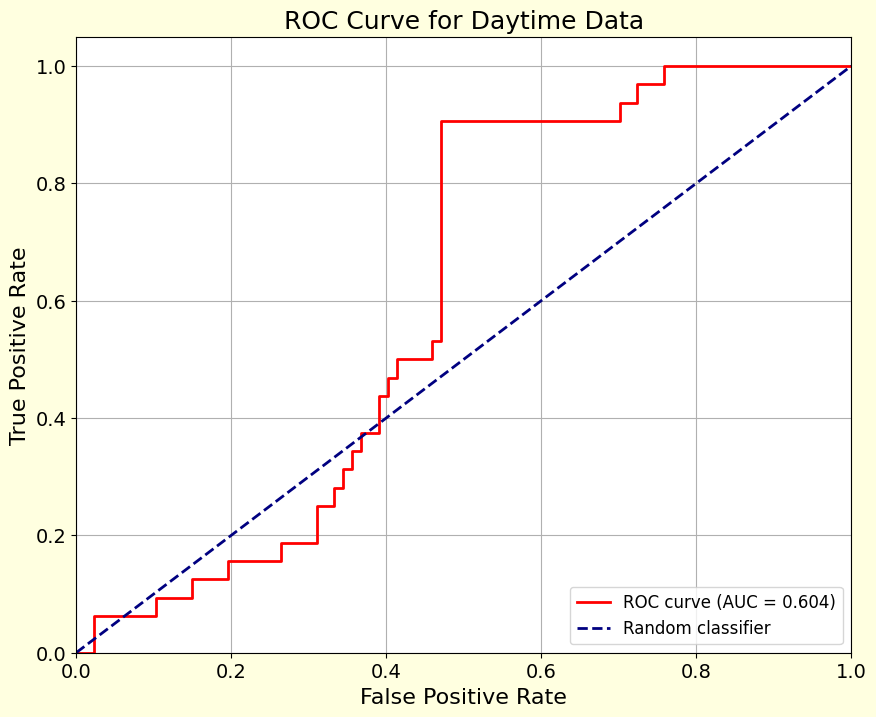


Area Under Curve (AUC): 0.604
Optimal threshold: 0.999
At optimal threshold:
True Positive Rate: 0.906
False Positive Rate: 0.471


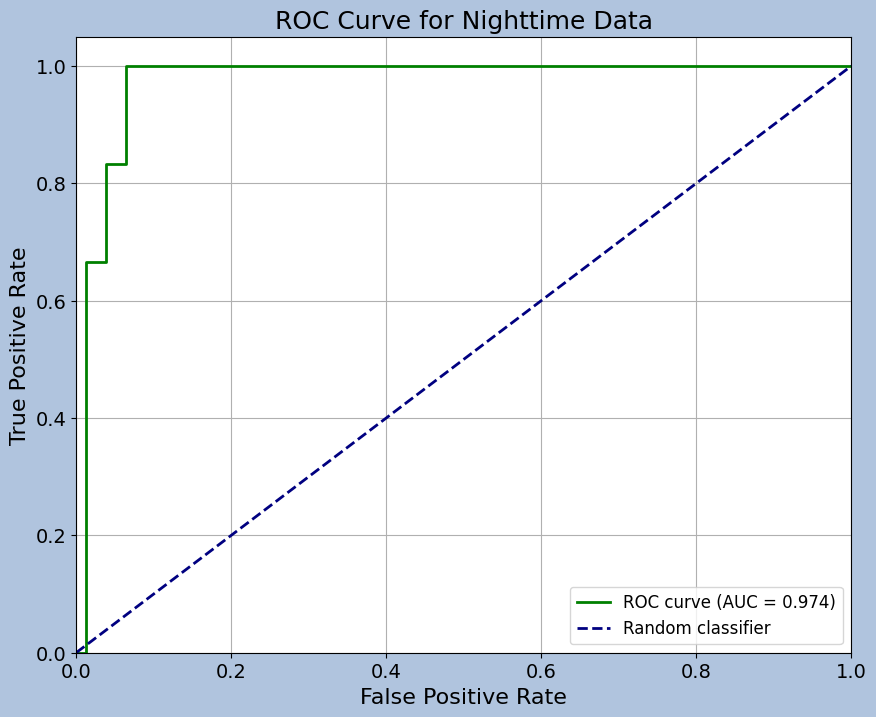


Area Under Curve (AUC): 0.974
Optimal threshold: 0.608
At optimal threshold:
True Positive Rate: 1.000
False Positive Rate: 0.065


In [36]:
plot_roc_curve(aggregate_data, "ROC Curve for Aggregate Data", bg_color='lightgray')
plot_roc_curve(daytime_data, "ROC Curve for Daytime Data", color='red', bg_color='lightyellow')
plot_roc_curve(nighttime_data, "ROC Curve for Nighttime Data", color='green', bg_color='lightsteelblue')

AttributeError: 'dict' object has no attribute 'fpr'

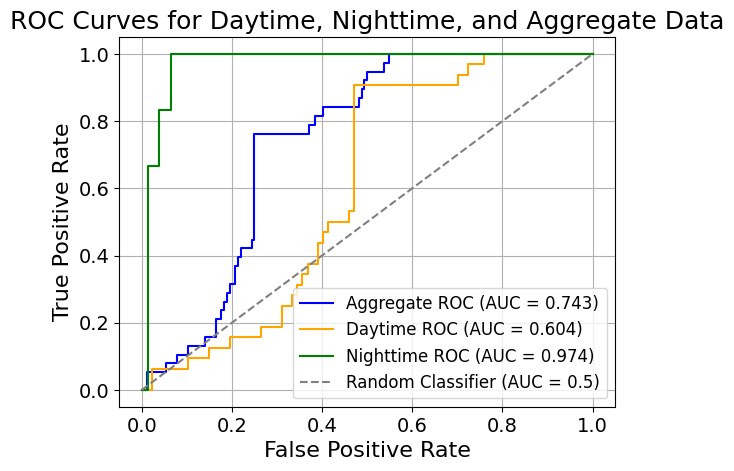

In [16]:
# Assuming your dictionaries are named `aggregate_data`, `daytime_data`, and `nighttime_data`
# and they contain 'fpr', 'tpr', and 'auc' keys

# ... existing code ...

# Plot ROC curves for aggregate, daytime, and nighttime
plt.plot(aggregate_data['fpr'], aggregate_data['tpr'], color='blue', label=f'Aggregate ROC (AUC = {aggregate_data["auc"]:.3f})')
plt.plot(daytime_data['fpr'], daytime_data['tpr'], color='orange', label=f'Daytime ROC (AUC = {daytime_data["auc"]:.3f})')
plt.plot(nighttime_data['fpr'], nighttime_data['tpr'], color='green', label=f'Nighttime ROC (AUC = {nighttime_data["auc"]:.3f})')

# Plot random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier (AUC = 0.5)')

# Set axis labels and title with larger font sizes
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves for Daytime, Nighttime, and Aggregate Data', fontsize=18)

plt.xticks(fontsize=14)  # Adjust the fontsize for x-axis ticks
plt.yticks(fontsize=14)

# Update legend to include all curves
plt.legend(loc="lower right", fontsize=10)  # Set fontsize to 10 or any smaller value you prefer
plt.grid(True)
plt.show()

# ... existing code ...